[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ncerdan/HandsOnML/blob/master/04_Training_Models.ipynb)

# Linear Regression

## The Normal Equation

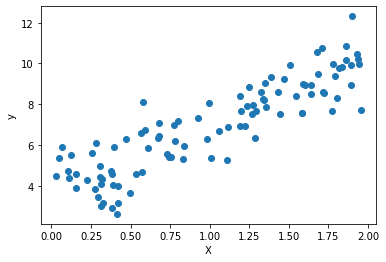

In [1]:
# make the data set
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1);
y = 4 + 3 * X + np.random.randn(100, 1)

plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [2]:
# now lets compute theta using the normal equation
X_b = np.c_[np.ones((100, 1)), X]   # adds x0 = 1 in front of all x rows in X
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best  # close to 4, 3 but noise of randomness made it adjust

array([[3.65859083],
       [3.23729117]])

In [3]:
# now can make predictions with it
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]

y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.65859083],
       [10.13317316]])

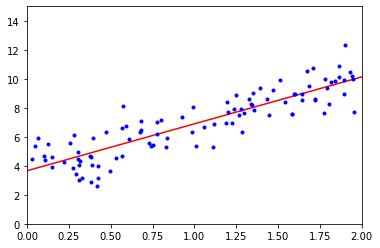

In [4]:
# visualize predictions
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [5]:
# now do it using sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)    # notice it splits bias term from others

print(lin_reg.predict(X_new))

[3.65859083] [[3.23729117]]
[[ 3.65859083]
 [10.13317316]]


In [6]:
# this class is based on the scipy least squares function which you can use directly
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd  #same as above

# this function computes pseudoinverse of X

array([[3.65859083],
       [3.23729117]])

In [7]:
# can use pinv to compute pseudoinverse directly too
np.linalg.pinv(X_b).dot(y)  # same too!

# this method is more efficient and can handle situation where inversion not possible

array([[3.65859083],
       [3.23729117]])

## Batch Gradient Descent

In [8]:
# uses the whole batch of X at each iteration
eta = 0.1   # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)   # random initialization

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)   # from calculus
    theta = theta - eta * gradients

theta   # same as normal equation!

array([[3.65859083],
       [3.23729117]])

## Stochastic Gradient Descent

In [9]:
# implements SGD with simple learning schedule
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparams

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)   # still random init

for epoch in range(n_epochs):
    for i in range(m):                          # m iterations per round
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta       # really close in only 50 rounds!

array([[3.70430582],
       [3.16467025]])

In [10]:
# to use this in sklearn use SGD
# defaults to minimizing squared error
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)  # tol = tolerance to terminate
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.64942523]), array([3.23068879]))

# Polynomial Regression



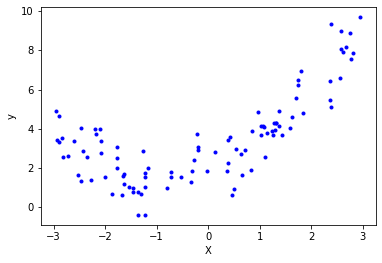

In [11]:
# make nonlinear data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, 'b.')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [12]:
# use sklearn's PolynomialFeatures to add the square of each feature as a new feature
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

# also adds combinations of features
# e.g. a, b --> poly_features(degree=3) --> a, a^2, a^3, b^2, b^3, ab, a^2b, ab^2

[-0.72723768]
[-0.72723768  0.52887464]


In [13]:
# now we can just fit it using LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.97265222]), array([[0.94416672, 0.51224287]]))

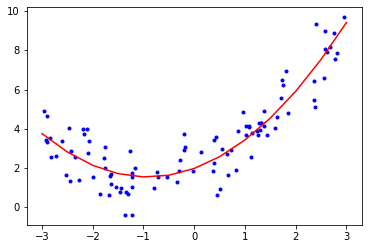

In [14]:
# visualize it
X_disp = np.arange(-3, 3.5, 0.5)

X_disp_poly = poly_features.fit_transform(X_disp.reshape(-1, 1))
y_disp = lin_reg.predict(X_disp_poly)

plt.plot(X, y, 'b.')
plt.plot(X_disp, y_disp, 'r-')
plt.show()

## Learning Curves

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.axis([0, 80, 0, 3])
    plt.legend()
    plt.show()

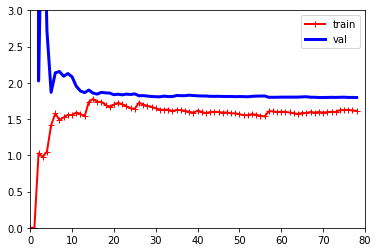

In [16]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

# both training and validation errors are similar but high = underfitting

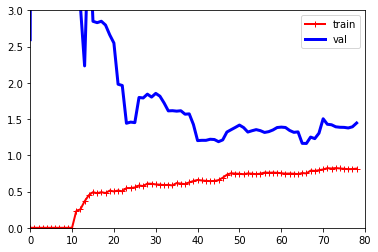

In [18]:
# now lets try it using a 10-degree polynomial
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
    ('poly_feature', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

# Notes:
#   lower error on training data, and gap between training and validation = overfitting

# Regularized Linear Models

## Ridge Regression

In [19]:
# closed form
from sklearn.linear_model import Ridge
# alpha = scaling of factorization term
# solver = matrix factorization method
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.81360472]])

In [20]:
# also using SGD
# penalty = regularization term (l2 makes it same as Ridge Regression)
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.78291442])

## Lasso Regression

In [21]:
# small example
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.76564266])

In [22]:
# alternatively
# penalty = l1 makes it same as Lasso Regression
sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.8158872])

## Elastic Net

In [23]:
# small example
from sklearn.linear_model import ElasticNet
# l1_ratio = r (from notes)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.7704382])

In [24]:
# alternatively
# penalty = elasticnet makes it same as Lasso Regression
sgd_reg = SGDRegressor(penalty='elasticnet')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.78404055])

## Early Stopping

In [ ]:
"""Basic Implementation.

Doesn't actually work bc not real dataset used.

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# prepare data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

# warm_string=True, continues training where it left off instead of starting from scratch
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate='constant', eta0=0.0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)   # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
"""

# Logistic Regression

## Decision Boundaries

In [27]:
# let's use the Iris dataset
from sklearn import datasets

iris = datasets.load_iris()
print(list(iris.keys()))
X = iris['data'][:, 3:] # petal width
y = (iris['target'] == 2).astype(np.int)    # 1 if Iris virginica, else 0

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']


In [32]:
# now let's train a LogisticRegression model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

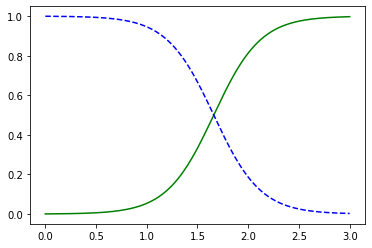

In [35]:
# let's look at the model's estimated probabilities
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)  # proba 0 col = prob for class 0, 1 col = prob for class 1
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Itis virginica')
plt.show()

In [39]:
# predict will make a decision based on which class has the higher prob
print(log_reg.predict([[1.7]])) # to right of intersection --> class 1
print(log_reg.predict([[1.5]])) # to left of intersection  --> class 0

[1]
[0]


In [41]:
# sklearn by default adds l2 regularization
# for LogisticRegression, magnitude of regularization is not controlled by alpha,
# but by C (alpha's inverse), therefore a large C = less regularization
# e.g. log_reg_2 = LogisticRegression(penalty='l1', C=0.01)

## Softmax Regression

In [42]:
# let's train one with 2D input
X = iris['data'][:, (2, 3)] # petal length, petal width
y = iris['target']

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# try it out
print(softmax_reg.predict_proba([[5, 2]]))
print(softmax_reg.predict([[5, 2]]))        # picks the class with the largest proba

[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]
[2]


# Exercises

## 1.) Which Lin Reg training alg could you use if you have millions of features?

Can't use closed form or SVD methods bc of bad complexity. Can instead use SGD, mini-batch GS, or even bath GD if memory allows

##2.) What algs suffer from differently-scaled features? What can you do about it?

GD will suffer, closed form will not. Instead, you can standardize you features.

## 3.) Can GD get stuck in a locl min when training a Logistic Regression model?

NO! The cose function if convex.

## 4.) Do all GD algs lead to the same model, provided they run long enough?

Yes, as long as the function is convex. However, if the learning rate is too high for SGD or mini-batch GD, they will never converge at the optimal value.

## 5.) If running Batch GD and you see validation error consistenly go up what is happening and what can you do?

It is overfitting. You can stop early or regularize.

## 6.) Should you stop Mini-batch GD as soon as validation error goes up?

No. With Mini-batch and SGD temporary increases in validation error are common because the algs are more erradic.

## 7.) Which GD algs are the fastest? Which will actually converge? How can you make the others converge as well?

Fastest = SGD bc only one training point per iteration. Mini-batch is fast too if you use a small mini-batch size. However, Batch GD is the only one that will actually converge. To make the others converge, you can lower the learning rate over time to force them to converge.

## 8.) Polynomial Regression learning curves show disparity between training and validation errors. What is happening and what can you do?

Probably overfitting. You can decrease degree of polynomial, add a regularization term, or get more data for your training set.

## 9.) Suppose using Ridge Regression and notice similar and high training and validation errors. Does the model suffer from high bias or high variance? Should you increase or decrease the magnitude of alpha (regularization constant)?

This means it is underfitting. This means that it is suffering from high bias. I should decrease alpha.

## 10.) Why would you want to use:
    a.) Ridge Regression instead of Linear Regression
    b.) Lasso instead of Ridge?
    c.) Elastic Net insetad of Lasso?

a.) If Linear Regression is overfitting
b.) If you want feature selection
c.) To prevent erradic behavior of Lasso

## 11.) Suppose you want a classifier for outdoor/indoor and daytime/nighttime. SHould you implement two Logistic Regression models or one softmax?

Should train 2 logistic regression models because those 4 classes are not mutually exclusive.

## 12.) Implement Batch Gradient Descent with early stopping for Softmax Regression without sklearn

In [ ]:
todo